# Diffusion Model

> Neural net modules

In [ ]:
#| default_exp models.diffusion

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms import transforms

import os
import logging
import warnings
from omegaconf import OmegaConf
from hydra.utils import instantiate
from tqdm.notebook import tqdm
from dataclasses import dataclass

from matplotlib import pyplot as plt
import numpy as np

from nimrod.utils import get_device, set_seed, time_it
from nimrod.image.datasets import ImageDataset, show_images, make_grid

from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.utils import make_image_grid
from diffusers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#| export
set_seed(42)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")

Seed set to 42


## DDPM Noise Scheduler: Noisify

In [ ]:
NOISE_TIME_STEPS = 1000
noise_scheduler = DDPMScheduler(
    num_train_timesteps=NOISE_TIME_STEPS,
    beta_schedule="squaredcos_cap_v2" # beter for small img sizes
    )

### Usage

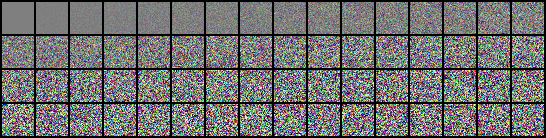

In [ ]:
B, C, H, W = 64, 3, 32, 32
xb = torch.zeros((B,C,H,W))
noise = torch.randn(xb.shape)
time_steps = torch.linspace(0, NOISE_TIME_STEPS-1, B).long()
noisy_images = noise_scheduler.add_noise(xb, noise, time_steps)
show_images(noisy_images, ncols=16)

## U-Net: Noise prediction

In [ ]:
B,C,H,W = xb.shape
model = UNet2DModel(
    sample_size=H,
    in_channels=C, 
    out_channels=C, 
    block_out_channels=(32, 64, 128, 128)
    )

### Usage

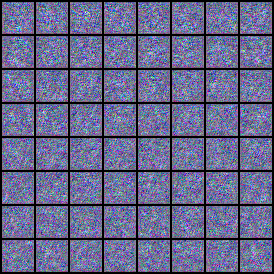

In [ ]:
with torch.no_grad():
    noise_pred = model(noisy_images, time_steps).sample

show_images(noise_pred)

## Training

### Data

[14:52:17] INFO - Init ImageDataModule for mnist


[14:52:27] INFO - split train into train/val [0.8, 0.2]
[14:52:27] INFO - train: 48000 val: 12000, test: 10000


num_classes: 10, batch_size: 512
labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
X: torch.Size([1, 32, 32]), Y: 7


Traceback (most recent call last):
  File "/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-jj6a98vk'


X: torch.Size([512, 1, 32, 32]), Y: torch.Size([512])


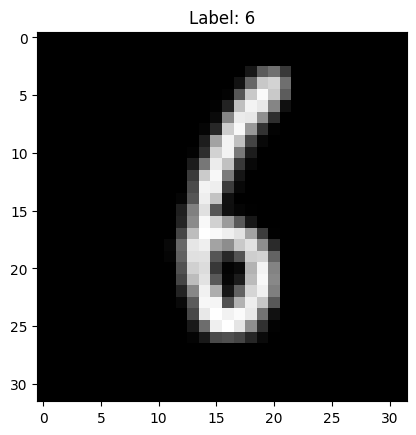

In [ ]:
#| no test

BATCH_SIZE = 512

cfg = OmegaConf.load('../config/data/image/mnist.yaml')
tfs = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize(32),
    # transforms.Normalize((0.1307,), (0.3081,))
    ]
    )

dm = instantiate(cfg, batch_size=BATCH_SIZE, transforms=tfs, num_workers=20)
dm.prepare_data()
dm.setup()

# check properties
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")

# sample
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")

# batch
xb,yb = next(iter(dm.train_dataloader()))
print(f"X: {xb.shape}, Y: {yb.shape}")
B,C,H,W = xb.shape
dm.show(0)


### Model

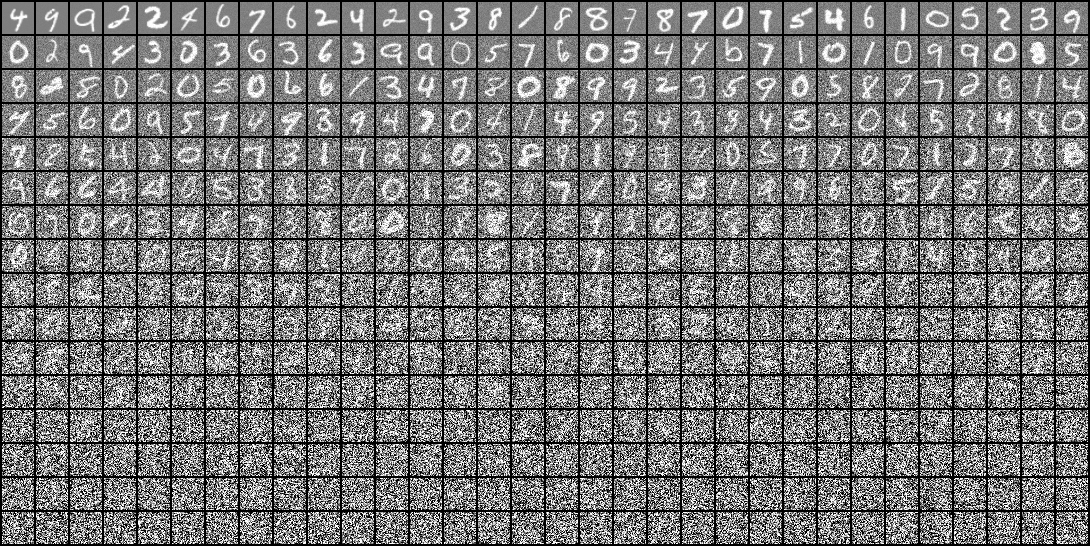

In [ ]:
#| notest

NOISE_TIME_STEPS = 1000
noise_scheduler = DDPMScheduler(
    num_train_timesteps=NOISE_TIME_STEPS,
    beta_schedule="squaredcos_cap_v2" # beter for small img sizes
    )

B,C,H,W = xb.shape

model = UNet2DModel(
    sample_size=H,
    in_channels=C, 
    out_channels=C, 
    block_out_channels=(32, 64, 128, 128)
    )
# generate gaussian noise images of shape (B, C, H, W)
noise = torch.randn(xb.shape)
# generate different time steps for each image in batch
time_steps = torch.linspace(0, NOISE_TIME_STEPS-1, B).long()
# generate more or less noise from scheduler depending on time step
noisy_images = noise_scheduler.add_noise(xb, noise, time_steps)
show_images(noisy_images, ncols=32)

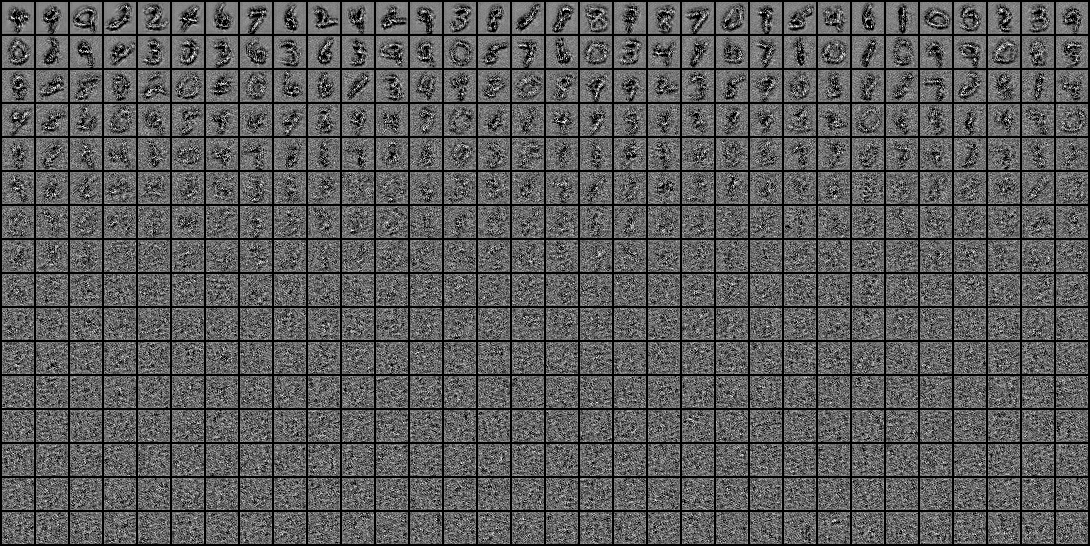

In [ ]:
#| notest

# predict noise from noisy image at time_step
with torch.no_grad():
    noise_pred = model(noisy_images, time_steps).sample

show_images(noise_pred, ncols=32)

### LR scheduler & optimizer

In [ ]:
#| notest

device = get_device()
print(f"device: {device}")

NOISE_TIME_STEPS = 1000
NUM_EPOCHS = 1
lr = 1e-4
lr_warmup_steps = 500
# total steps =number of batches * num_epochs
num_training_steps = len(dm.train_dataloader()) * NUM_EPOCHS
print(f"num_training_steps: {num_training_steps}")

model = UNet2DModel(
    sample_size=H,
    in_channels=C,
    out_channels=C,
    block_out_channels=(32, 64, 128, 256)
    )

model.to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=NOISE_TIME_STEPS)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

criterion = nn.MSELoss()

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=num_training_steps
)


Seed set to 42
[15:16:11] INFO - Using device: cuda


device: cuda
num_training_steps: 94


### Training Loop

In [ ]:
#| notest

train_step_losses = []
val_step_losses = []
lrs = []

for epoch in range(NUM_EPOCHS):
    i = 0
    model.train()
    n_steps, total_loss = 0, 0

    for step, (images, labels) in tqdm(enumerate(dm.train_dataloader()), total=len(dm.train_dataloader()), leave=False):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        B, C, H, W = images.shape
        # sample noise
        noise = torch.randn(images.shape).to(device)
        # sample random timesteps
        # timesteps = torch.randint(0, NOISE_TIME_STEPS, (images.shape[0],)).to(device)
        timesteps = torch.randint(0, NOISE_TIME_STEPS, (B,)).to(device)
        # create noisy image at timestep with noise scheduler
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        # train model to predict noise
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        # output should be as close to input as possible
        loss = criterion(noise_pred, noise)
        n_steps += len(images)
        total_loss += (loss.item() * len(images))
        train_step_losses.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        # logger.info(f"loss.item(): {loss.item()}, len(images): {len(images)}")
        # logger.info(f"Epoch: {epoch}, step: {step}, n_steps: {n_steps}, loss: {loss.item()}")
        loss.backward()
        optimizer.step()
        lr_scheduler.step()


    logger.info(f"Epoch: {epoch} train_loss: {total_loss / n_steps}")

    model.eval()
    total_loss, n_steps = 0, 0
    for step, (images, labels) in tqdm(enumerate(dm.val_dataloader()), total=len(dm.val_dataloader()), leave=False):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # sample noise
        noise = torch.randn(images.shape).to(device)
        # sample random timesteps
        timesteps = torch.randint(0, NOISE_TIME_STEPS, (images.shape[0],)).to(device)
        # create noisy image at timestep with noise scheduler
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        # train model to predict noise
        outputs = model(noisy_images, timesteps, return_dict=False)[0]
        # output should be as close to input as possible

        loss = criterion(outputs, noise)
        val_step_losses.append(loss.item())
        n_steps += len(images) # bs
        total_loss += loss.item() * len(images)
        # logger.info(f"Epoch: {epoch}, step: {step}, n_steps: {n_steps}, loss: {loss.item()}")
    logger.info(f"Epoch: {epoch} val_loss: {total_loss / n_steps}") 


  0%|          | 0/94 [00:00<?, ?it/s]

[15:16:34] INFO - Epoch: 0 train_loss: 0.9706958387692769


  0%|          | 0/24 [00:00<?, ?it/s]

[15:16:36] INFO - Epoch: 0 train_loss: 0.5300325419108073


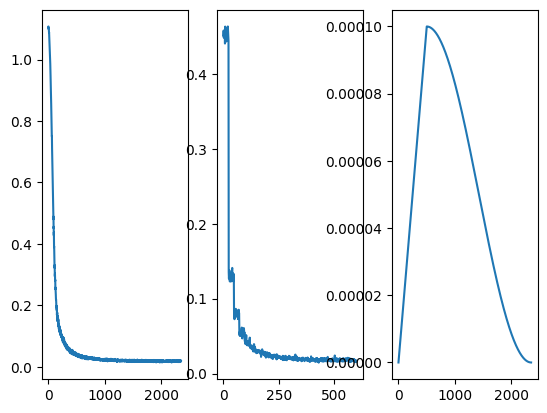

In [ ]:
#| notest

fig, axs = plt.subplots(1,3)
axs[0].plot(train_step_losses)
axs[1].plot(val_step_losses)
axs[2].plot(lrs)
plt.show()

### Test Image Generation

  0%|          | 0/1000 [00:00<?, ?it/s]

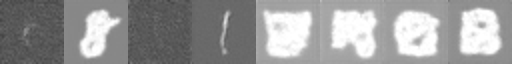

In [ ]:
#| notest

# Using pre-defined HF pipeline
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler).to(device)
img_gen = pipeline(batch_size=8)
make_grid(img_gen.images)

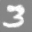

In [ ]:
#| notest
img_gen.images[0]


In [ ]:
#| notest

# use our own sampler based on noise_scheduler

@time_it
def generate_image(model, images_shape, device, noise_scheduler):
    # start with noise images (B,C,H,W)
    sample = torch.randn(images_shape).to(device)
    for i, t in enumerate(noise_scheduler.timesteps):
        with torch.no_grad():
            # predict noise 
            residual = model(sample, t).sample
            # update sample with step
            sample = noise_scheduler.step(residual, t, sample).prev_sample


    # sample = (sample / 2 + 0.5).clamp(0, 1)
    return sample

        # plt.imshow(image[0].permute(1,2,0).cpu().numpy())

In [ ]:
#| notest

images = generate_image(model, (B,C,H,W), device, noise_scheduler)

generate_image: 43.623 seconds


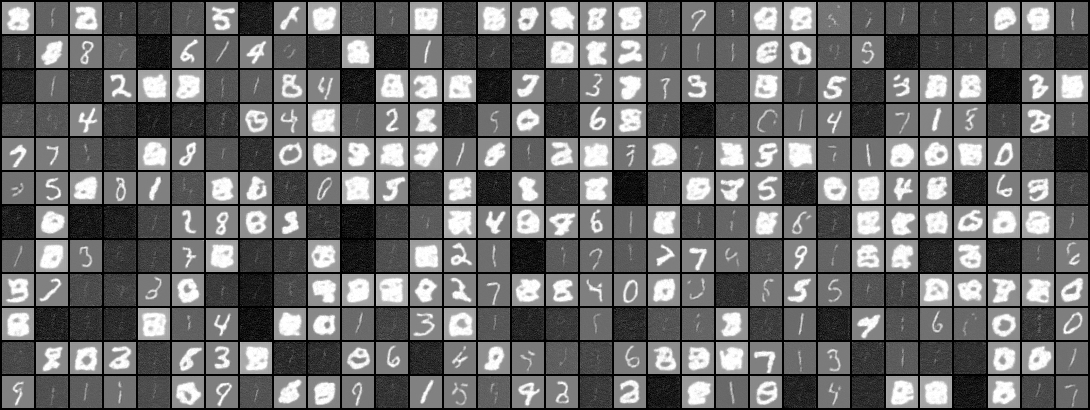

In [ ]:
#| notest
show_images(images, ncols=32)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()